In [1]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from glob import glob
from hydra import initialize, compose
from lenstronomy.Plots import plot_util

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.plots import overplot, plot
from mejiro.lenses import lens_util
from mejiro.utils import util

In [2]:
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = pipeline_params['debugging']

if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir

print(f'pipeline_dir: {pipeline_dir}')

pipeline_dir: /data/bwedig/mejiro/pipeline


In [ ]:
lens, rgb_model, rgb_image = lens_util.get_sample(pipeline_dir, 52)

plt.imshow(rgb_image)
plt.title(rgb_image.shape)
plt.show()

In [ ]:
num_pix = 45
coords = lens_util.get_coords(num_pix)

r_image = rgb_image[:, :, 0]
g_image = rgb_image[:, :, 1]
b_image = rgb_image[:, :, 2]

r_image = util.center_crop_image(r_image, (num_pix, num_pix))
g_image = util.center_crop_image(g_image, (num_pix, num_pix))
b_image = util.center_crop_image(b_image, (num_pix, num_pix))

rgb_image = np.stack([r_image, g_image, b_image], axis=2)
print(rgb_image.shape)

In [ ]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.imshow(rgb_image, cmap='binary')

overplot.source_position(ax, lens, coords, alpha=1, color='orange', size=7.5)
overplot.lens_position(ax, lens, coords, alpha=1, color='red', size=7.5)
overplot.caustics(ax, lens, coords, num_pix, delta_pix=0.11, linewidth=2.5, alpha=0.6, color='g')
overplot.critical_curves(ax, lens, coords, num_pix, delta_pix=0.11, linewidth=2.5, alpha=0.6, color='b')

plot_util.scale_bar(ax, d=rgb_image.shape[0], dist=1 / 0.11, text='1"', color='w', flipped=True)
# plot_util.coordinate_arrows(ax, d=lens.num_pix * .95, coords=lens.coords, color='w', font_size=15, arrow_size=0.02)

plt.axis(False)
# plt.legend(fontsize=12, bbox_to_anchor = (1.65, 0.5), loc='center right')

plt.savefig(os.path.join(figure_dir, 'roman_image.png'))
plt.show()

In [ ]:
from lenstronomy.Plots import lens_plot

f, axex = plt.subplots(1, 1, figsize=(5, 5))
lens_plot.lens_model_plot(axex, lensModel=lens.lens_model_class, kwargs_lens=lens.kwargs_lens,
                          sourcePos_x=lens.kwargs_source_dict['F106']['center_x'],
                          sourcePos_y=lens.kwargs_source_dict['F106']['center_y'], point_source=True,
                          with_caustics=True, fast_caustic=False, coord_inverse=False)

[critical lines are confusing, but this looks right](https://www.researchgate.net/figure/Three-basic-configurations-of-quad-lenses-cusp-top-fold-middle-and-cross-bottom_fig2_301817913)

In [3]:
from mejiro.instruments.roman import Roman
from mejiro.synthetic_image import SyntheticImage
from mejiro.exposure import Exposure
from mejiro.lenses.test import SampleStrongLens

roman = Roman()
lens = SampleStrongLens()
bands = ['F106', 'F129', 'F184']
scene_size = 5  # arcsec
oversample = 5
exposure_time = 146

realization = lens.generate_cdm_subhalos()
lens.add_subhalos(realization)

exposures = []
for band in bands:
    synthetic_image = SyntheticImage(strong_lens=lens,
                                     instrument=roman,
                                     band=band,
                                     arcsec=scene_size,
                                     oversample=oversample)

    exposure = Exposure(synthetic_image,
                        exposure_time=exposure_time,
                        check_cache=True)

    exposures.append(exposure.exposure)

Computing on pixel grid of size 235x235 (5.17"x5.17") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Computing with kwargs_numerics: {'supersampling_factor': 3, 'compute_mode': 'adaptive', 'supersampled_indexes': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}
Initialized SyntheticImage for StrongLens SAMPLE by Roman in F106 band
Loading cached PSF: /data/bwedig/mejiro/cached_psfs/F106_1_2048_2048_5_101.npy
Exposure calculation time with galsim engine: 0:00:04
Computing on pixel grid of size 235x235 (5.17"x5.17") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Computing with kwargs_numerics: {'supersampling_

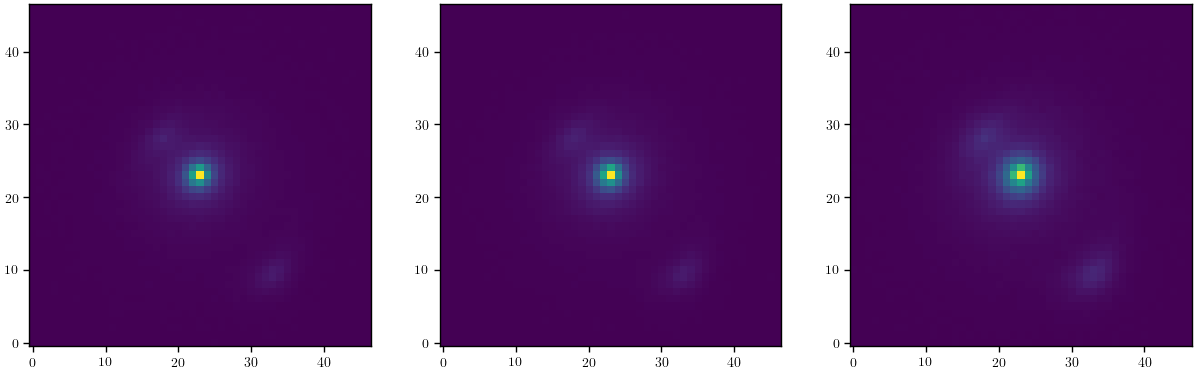

In [4]:
exposures = [i / 146 for i in exposures]

_, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, a in enumerate(ax):
    a.imshow(exposures[i])

In [5]:
from pprint import pprint

pprint(lens.kwargs_source_dict['F106'])

{'R_sersic': 0.1651633078964498,
 'center_x': 0.30298310338567075,
 'center_y': -0.3505004565139597,
 'e1': -0.06350855238708408,
 'e2': -0.08420760408362458,
 'magnitude': 21.434711611915137,
 'n_sersic': 1.0}


In [6]:
# from lenstronomy.Plots import lens_plot
# f, axex = plt.subplots(1, 1, figsize=(5, 5))
# lens_plot.lens_model_plot(axex, lensModel=lens.lens_model_class, kwargs_lens=lens.kwargs_lens, sourcePos_x=lens.kwargs_source_dict['F106']['center_x'], sourcePos_y=lens.kwargs_source_dict['F106']['center_y'], point_source=True, with_caustics=True, fast_caustic=False, coord_inverse=False)

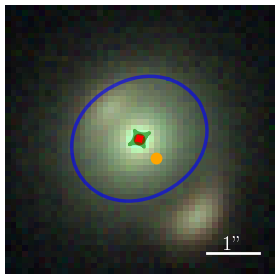

In [13]:
from mejiro.helpers import color

rgb_image = color.get_rgb(image_b=exposures[0], image_g=exposures[1], image_r=exposures[2], stretch=4, Q=6)

fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.imshow(rgb_image, cmap='binary')

coords = lens_util.get_coords(rgb_image.shape[0])
overplot.source_position(ax, lens, coords, alpha=1, color='orange', size=7.5)
overplot.lens_position(ax, lens, coords, alpha=1, color='red', size=7.5)
overplot.caustics(ax, lens, coords, num_pix=synthetic_image.native_num_pix, delta_pix=0.11, linewidth=2.5, alpha=0.6,
                  color='g')
overplot.critical_curves(ax, lens, coords, num_pix=synthetic_image.native_num_pix, delta_pix=0.11, linewidth=2.5,
                         alpha=0.6, color='b')

plot_util.scale_bar(ax, d=rgb_image.shape[0], dist=1 / 0.11, text='1"', color='w', flipped=True)
# plot_util.coordinate_arrows(ax, d=lens.num_pix * .95, coords=lens.coords, color='w', font_size=15, arrow_size=0.02)

plt.axis(False)
# plt.legend(fontsize=12, bbox_to_anchor = (1.65, 0.5), loc='center right')

plt.savefig(os.path.join(figure_dir, 'roman_image.png'))
plt.show()